In [1]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap
import glob
import TestingTrainingSplit_CV

# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/*_TrendMaps.nc'
ModelNames = [i[44:-16] for i in glob.glob(path_to_data)]

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = TestingTrainingSplit_CV.training_testing_split()

In [21]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import LinearRegression
from scipy import stats

#
ERA5Trend1996_2014 = np.load('/home/disk/p/aodhan/SurfaceTrendLearing/FileCreators/ERA5Trend1996_2014.npy')
ERA5Trend1996_2014_reshaped = np.reshape(ERA5Trend1996_2014, (72*144))

# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
ERA5_predictions = []

for model_idx in range(len(ModelNames)):
    # Reshape target and predictor data for model
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
    TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))

    # Model Design
    pls = SGDRegressor(penalty='l1')
    Y_preds = []
    ERA5_preds = []
    
    for x in range(6):
        # Train model
        #scaler.fit(TrainingPredictorData[model_idx])
        #TrainingPredictorDataOneModel = scaler.transform(TrainingPredictorData[model_idx])
        #TestingPredictorDataOneModel = scaler.transform(TestingPredictorData[model_idx])
        
        # fit model
        pls.fit(TrainingPredictorData[model_idx], TrainingTargetDataReshaped[:,x])

        # Predict using trained model
        Y_pred = pls.predict(TestingPredictorData[model_idx])
        Y_preds.append(Y_pred)

        # Apply trained model to observations
        Y_pred_obs = pls.predict(ERA5Trend1996_2014_reshaped.reshape(1, -1))
        ERA5_preds.append(Y_pred_obs)
    Y_preds = np.transpose(Y_preds)
    ERA5_preds = np.transpose(ERA5_preds)
    NameValidatationPredictions.append([ModelNames[model_idx], TestingTargetDataReshaped, Y_preds])
    ERA5_predictions.append(ERA5_preds)

In [22]:
print('Natural: ', np.nanmean(ERA5_predictions, axis=0)[0,2])
print('Forced: ', np.nanmean(ERA5_predictions, axis=0)[0,5])
print('Sum: ', np.nanmean(ERA5_predictions, axis=0)[0,2] + np.nanmean(ERA5_predictions, axis=0)[0,5])

Natural:  -0.1987337976684661
Forced:  0.26246044440334754
Sum:  0.06372664673488143


Text(0.5, 1.0, 'SGD Regression: r = 0.93')

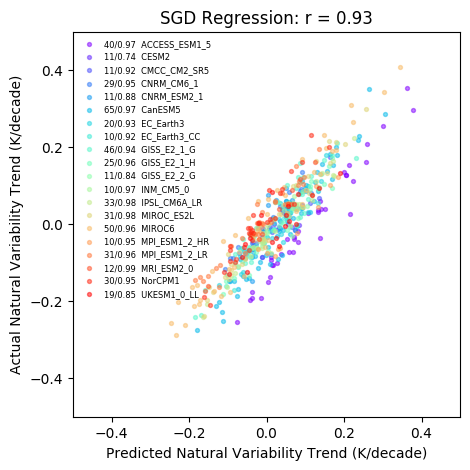

In [19]:
fig, axs_obj = plt.subplots(1, 1, figsize=(5, 5))
import matplotlib.cm as cm

####################################################################################
ERA5Trend1996_2014 = np.load('/home/disk/p/aodhan/SurfaceTrendLearing/FileCreators/ERA5Trend1996_2014.npy')
ERA5Trend1996_2014_reshaped = np.reshape(ERA5Trend1996_2014, (72*144))
colors = cm.rainbow(np.linspace(0, 1, 20))
all_r_values = []
ERA5_predictions = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)

    r_values = []
    for predictant_idx in range(2,3):
        val = ValidationData[:,predictant_idx]
        pred = PredictedData[:,predictant_idx]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(PredictedData[:,predictant_idx], ValidationData[:,predictant_idx], label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)

        axs_obj.set_ylim(-.5,.5)
        axs_obj.set_xlim(-.5,.5)
        axs_obj.set_ylabel('Actual Natural Variability Trend (K/decade)')
        axs_obj.set_xlabel('Predicted Natural Variability Trend (K/decade)')
    all_r_values.append(r_values)
axs_obj.set_title('SGD Regression: r = ' + str(np.nanmean(all_r_values))[:4])



/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


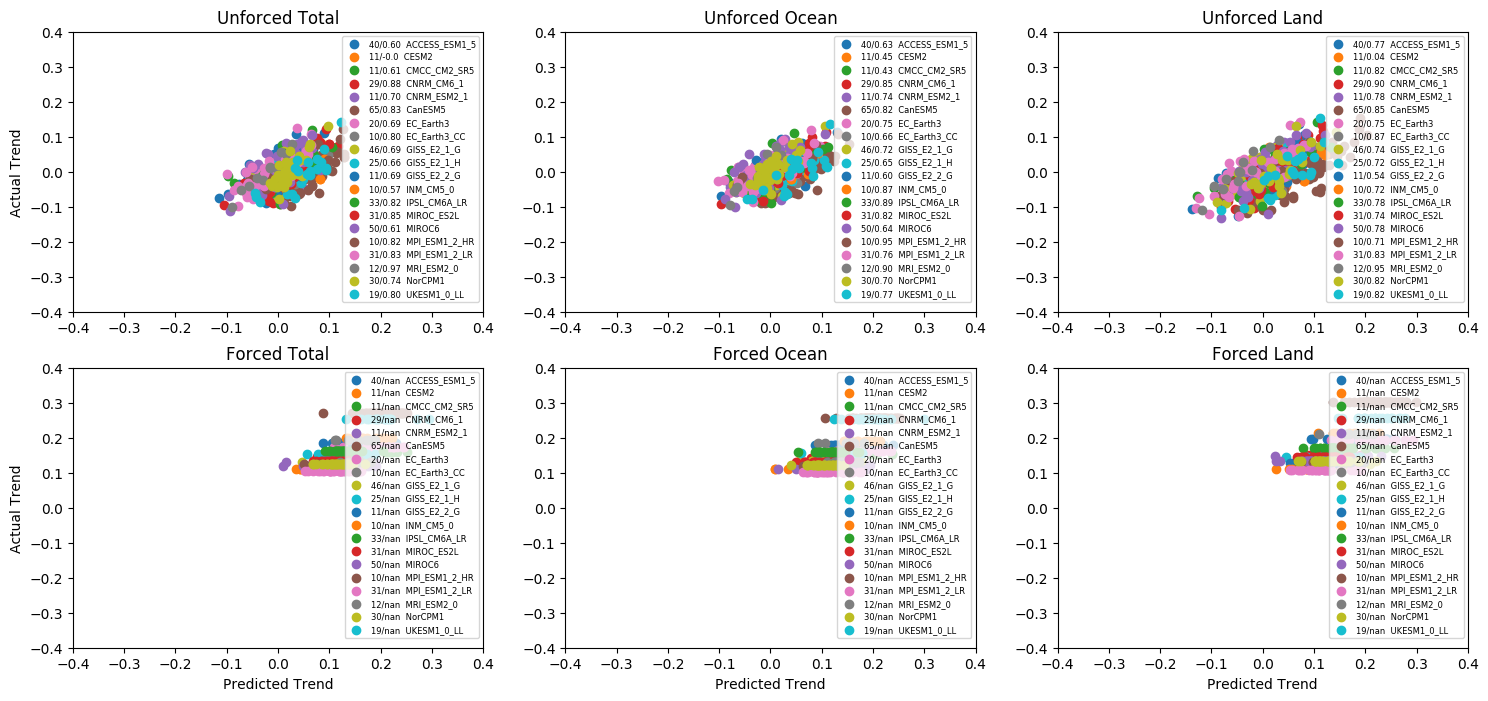

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(18,8))

# the second axis in ValidationData and PredictedData is stored as follows
titles = ['Unforced Total', 'Unforced Ocean', 'Unforced Land', 'Forced Total', 'Forced Ocean', 'Forced Land']

all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)

    r_values = []
    for predictant_idx in range(6):
        val = ValidationData[:,predictant_idx]
        pred = PredictedData[:,predictant_idx]

        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        axs_obj = axs.flatten()[predictant_idx]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(PredictedData[:,predictant_idx], ValidationData[:,predictant_idx], label=label_id)
        axs_obj.legend(loc=1, prop={'size': 6})
        axs_obj.set_ylim(-.4,.4)
        axs_obj.set_xlim(-.4,.4)
        axs_obj.set_title(titles[predictant_idx])
        if (predictant_idx == 0) or (predictant_idx == 3):
            axs_obj.set_ylabel('Actual Trend')
        if (predictant_idx >=3):
            axs_obj.set_xlabel('Predicted Trend')
    all_r_values.append(r_values)


In [4]:
np.shape(TestingPredictorData[1])

(11, 10368)

In [5]:
thing = np.reshape(TestingPredictorData[1], (11, 72, 144))

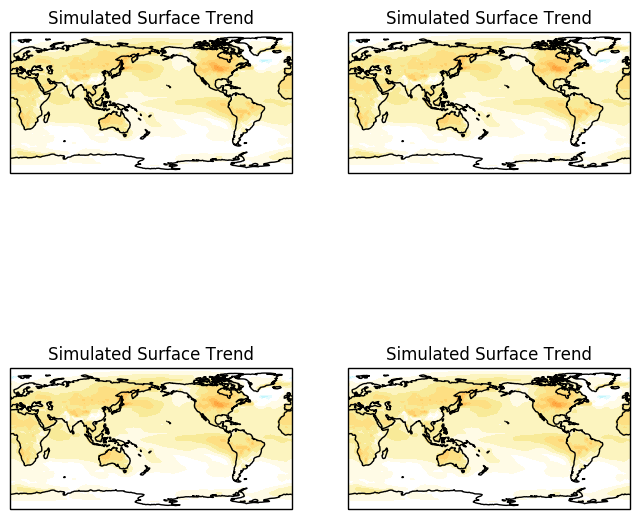

In [13]:
#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)
lim = np.linspace(-1, 1, 21)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))

fig, axs = plt.subplots(2,2,figsize=(8,8), subplot_kw=subplot_kw)
axs_obj = axs.flatten()
for x in range(4):
    axs_obj[x].coastlines()
    #ax[0].set_extent([0.0, -1, -90.0, 90.0])
    axs_obj[x].set_title('Simulated Surface Trend')
    coef_map_cyclic, lon = add_cyclic_point(forced, coord=lon_bins)
    im = axs_obj[x].contourf(lon, lat_bins, coef_map_cyclic,levels=lim,
                        transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
    #axs_obj[x].contourf(thing[x], np.linspace(-1.5,1.5,21), cmap=custom_cmap)

In [12]:
forced = np.nanmean(thing, axis=0)